In [30]:
import numpy as np

In [31]:
# initialize NN and set parameters
input_size = 9 
output_size = 9
epsilon = 0.0 # Probabilty to take random actions
gamma = 0.7 # Discount factor
learning_rate = 1e-2
decay_rate = 0.99

W1 = np.random.randn(input_size, output_size) / np.sqrt(output_size)
b1 = np.random.randn(output_size) / np.sqrt(output_size)

def forward_pass(x):
    return np.dot(x,W1) + b1

def backward_pass(X, Y_diff):
    dW = np.dot(X.T,Y_diff)
    db = np.mean(Y_diff, axis = 0)
    return dW, db

def get_propabilities(x):
    z = x - np.max(x)
    return np.exp(z)/np.sum(np.exp(z))


#print(f'{W1=}\n {b1=}') 

In [32]:
class LinearModel:
    def __init__(self):
        self.W1 = np.random.randn(output_size, input_size) / np.sqrt(input_size)
        self.b1 = np.random.randn(output_size) / np.sqrt(output_size)

    def forward_pass(self, x):
        x1 =  np.dot(self.W1, x) + self.b1
        return x1, None # no hidden layer, so we output a None 
    
    def backward_pass(self, X, Y_diff):
        dW = np.dot(X.T,Y_diff)
        db = np.mean(Y_diff, axis = 0)
        return {'W1':dW, 'b1':db}
    
    def get_propabilities(self, x):
        return np.exp(x)/np.sum(np.exp(x))

In [33]:
class NonlinearModel:
    def __init__(self, hl_size = 9):
        self.W1 = np.random.randn(hl_size, input_size) / np.sqrt(input_size)
        self.W2 = np.random.randn(output_size, hl_size) / np.sqrt(hl_size)
        self.b1 = np.random.randn(hl_size) / np.sqrt(hl_size)

    def preprocessing(self,x):
        x[x == 2] = -1
        return x

    def forward_pass(self, x):
        x1 =  np.dot(self.W1, x) + self.b1
        x1[x1 < 0] = 0 # relu
        x2 = np.dot(self.W2, x1)
        return x2, x1
    
    def backward_pass(self, X, H, Y_diff):
        #dW2 = np.dot(H.T, Y_diff)
        dW2 = np.dot(Y_diff.T, H)
        dh = np.dot(Y_diff, self.W2)
        #dh = np.dot(self.W2.T, Y_diff)
        dh[H <= 0] = 0 # backpro prelu
        db = np.mean(dh, axis = 0)
        dW1 = np.dot(dh.T, X)
        return {'W1':dW1, 'W2':dW2, 'b1': db}
    
    def get_propabilities(self, x):
        return np.exp(x)/np.sum(np.exp(x))


In [34]:
dummy_x = np.random.randn(9)

logits = forward_pass(dummy_x)
probabilities = get_propabilities(logits)
print(f'{logits=}\n {probabilities=}')

logits=array([-1.01581534, -1.07999139, -1.62186857,  0.37668175, -0.53029978,
       -0.57045796,  2.31653265,  1.27756235,  1.67167845])
 probabilities=array([0.01605099, 0.01505326, 0.00875581, 0.06460343, 0.02608306,
       0.02505636, 0.44949219, 0.1590388 , 0.2358661 ])


In [35]:
def print_board(s):
    x = ['-', 'x', 'o']
    print(f' [{x[s[0]]} {x[s[1]]} {x[s[2]]}] \n [{x[s[3]]} {x[s[4]]} {x[s[5]]}] \n [{x[s[6]]} {x[s[7]]} {x[s[8]]}] \n')

def get_discounted_rewards(actions, reward):
    rewards = [reward * gamma**i for i in range(len(actions))]
    return rewards[::-1]    

In [36]:
# define game loop. Start with the Ai always starting and the opponent going second
ai_token = 1
opponent_token = 2

def take_random_action(board, token):
    free_indices = [i for i, val in enumerate(board) if val == 0]
    action = np.random.choice(free_indices)
    board[action] = token
    return action, board

def take_action(board, logits, token):
    if epsilon > np.random.random_sample():
        action, board = take_random_action(board, token)
    else:
        free_indices = [i for i, val in enumerate(board) if val == 0]
        l_free = logits[free_indices] # get logits of possible moves
        p = get_propabilities(l_free)
        action = np.random.choice(free_indices, p=p)
        board[action] = token
    return action, board

def check_winner(board):

    winning_combinations = [
        (0, 1, 2), (3, 4, 5), (6, 7, 8),
        (0, 3, 6), (1, 4, 7), (2, 5, 8),
        (0, 4, 8), (2, 4, 6)
    ]
    for combo in winning_combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] != 0:
            return board[combo[0]] 
    return 0

def get_reward(winner):
    if winner == ai_token:
        return 1
    elif winner == opponent_token:
        return -1
    else:
        return 0

def play_game(model, verbose = False):
    board = [0] * 9
    boards_arr, actions_arr, logits_arr, h_arr  = [], [], [], []
    for t in range(9):
        if t%2 == 0:
            boards_arr.append(board.copy())
            logits, h = model.forward_pass(board)
            action, board = take_action(board, logits, ai_token)
            actions_arr.append(action) 
            logits_arr.append(logits)
            h_arr.append(h)
        else:
            action, board = take_random_action(board, opponent_token)   
        winner = check_winner(board)
        reward = get_reward(winner)
        if verbose:
            print_board(board)
        if reward:
            break    
    return {'boards': boards_arr, 
            'actions':actions_arr, 
            'logits': logits_arr,
            'reward': reward,
            'hidden_layer': h_arr}

model = NonlinearModel()
game = play_game(model)
game

{'boards': [[0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 1, 2, 0, 0, 0, 0, 0, 0],
  [2, 1, 2, 1, 0, 0, 0, 0, 0],
  [2, 1, 2, 1, 0, 0, 1, 0, 2]],
 'actions': [np.int64(1), np.int64(3), np.int64(6), np.int64(7)],
 'logits': [array([ 0.07323406,  0.13378852, -0.00250077, -0.02914517,  0.01249263,
          0.10113459, -0.01604843, -0.03791101, -0.02538965]),
  array([ 0.17351156,  0.27410315,  0.35179634,  0.25141834, -0.12467358,
         -0.06640643,  0.33518613, -0.41061891, -0.02208668]),
  array([ 0.2871003 ,  0.69058225,  0.55631352,  0.26417893, -0.15464851,
          0.06417243,  0.52638042, -0.56749122,  0.1909314 ]),
  array([ 0.40602307,  0.67093441,  0.51266114,  0.21098079, -0.08361966,
          0.11247764,  0.42841206, -0.42352005,  0.28496492])],
 'reward': -1,
 'hidden_layer': [array([0.        , 0.09851883, 0.15572453, 0.02965965, 0.25664765,
         0.        , 0.        , 0.        , 0.08224494]),
  array([0.        , 0.        , 0.        , 0.38240513, 0.        ,
         0. 

In [37]:
epoche = 100 # Do x training episodes
n = 2000 # play x games

def get_ydiff(logits, actions):
    y_diff = []
    for lg, a in zip(logits, actions):
        act_arr = [0] * 9
        act_arr[a] = 1
        y_diff.append(act_arr - get_propabilities(lg))
    return y_diff


model = NonlinearModel(hl_size=100)
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.__dict__.items() } # rmsprop memory
Rout = []

for e in range(epoche):
    X, y_diff, R, H = [], [], [], [] # X : Training Data of board states, y_diff Difference between action taken and output probabilities
    R_sum = 0
    # R: Rewards for the (X,y) samples, H: Hidden Layer activations
    for i in range(n):
        #boards, actions, logits, reward = play_game()
        game = play_game(model)
        rewards = get_discounted_rewards(game['actions'], game['reward'])
        diff = get_ydiff(game['logits'], game['actions'])

        X.append(game['boards'])
        y_diff.append(diff)
        R.append(rewards)
        H.append(game['hidden_layer'])
        R_sum += game['reward']

    # reduce dimensionality to avoid problems with different game length
    Xeps = np.array([b for g in X for b in g]) 
    yeps = np.array([y for g in y_diff for y in g])
    Reps = np.array([r for g in R for r in g])
    heps = np.array([h for g in H for h in g])

    # normalize the rewards
    Reps -= np.mean(Reps)
    Reps /= np.std(Reps)

    yeps *= Reps[:, np.newaxis] # mutiply gradient and reward

    #print(Xeps.shape, heps.shape, yeps.shape)

    if isinstance(model, LinearModel):
        grad = model.backward_pass(Xeps, yeps)
    if isinstance(model, NonlinearModel):
        grad = model.backward_pass(Xeps, heps, yeps) 

    for k,v in model.__dict__.items():
        #print(k)
        g = grad[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model.__dict__[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
    
    print(R_sum/n)
    Rout.append(R_sum/n)

0.265
0.4695
0.4345
0.5275
0.5345
0.577
0.68
0.682
0.742
0.739
0.666
0.759
0.7545
0.7155
0.7755
0.6995
0.775
0.7765
0.696
0.715
0.7025
0.7835
0.707
0.7355
0.709
0.792
0.703
0.7405
0.723
0.7505
0.7155
0.7915
0.7395
0.7515
0.7195
0.743
0.713
0.6815
0.7335
0.758
0.727
0.7705
0.694
0.693
0.762
0.7055
0.7525
0.7045
0.7525
0.7235
0.746
0.7365
0.7665
0.755
0.7805
0.737
0.73
0.751
0.7555
0.73
0.6935
0.76
0.7605
0.739
0.7615
0.747
0.7455
0.7335
0.7675
0.722
0.7685
0.6735
0.7525
0.772
0.6905
0.751
0.7385
0.715
0.71
0.752
0.742
0.7385
0.703
0.75
0.739
0.7215
0.7405
0.7455
0.7305
0.7335
0.746
0.773
0.721
0.746
0.744
0.7345
0.7305
0.74
0.7625
0.712


Text(0, 0.5, 'score')

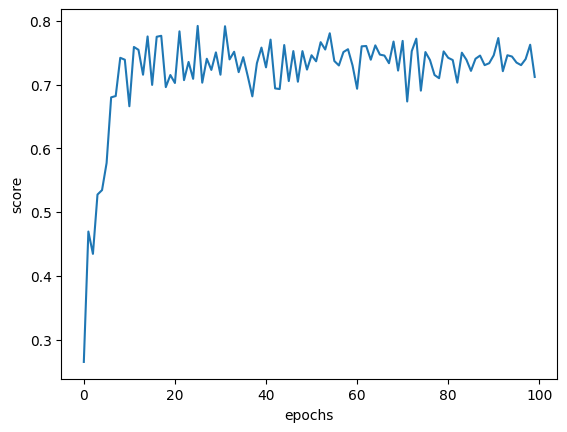

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(Rout)
ax.set_xlabel('epochs')
ax.set_ylabel('score')

In [39]:
board = [0] * 9
#board[3] = 1
#board[1] = 2
logits, h = model.forward_pass(board)
probs = get_propabilities(logits)
probs

array([2.52324784e-267, 1.49590222e-266, 1.00000000e+000, 7.11563770e-267,
       7.20872570e-093, 5.54729058e-219, 6.65716937e-099, 1.82071992e-263,
       4.81593012e-224])

In [42]:
epsilon = 0.0
test = play_game(model, verbose = True)


 [- - x] 
 [- - -] 
 [- - -] 

 [- - x] 
 [o - -] 
 [- - -] 

 [- - x] 
 [o x -] 
 [- - -] 

 [- - x] 
 [o x o] 
 [- - -] 

 [- - x] 
 [o x o] 
 [x - -] 

